In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np


def one_hot_encoder(training_path, val_path, test_path):
    # Get training data from files
    training_data = []
    decoder_input = []
    decoder_output = []
    with open(training_path, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            # Separate Chinese and English, line[0] is the English sentence and line[1] is the translated Chinese
            line = line.split(' 	')
            line[0] += '[EOS]'
            line[0] = '[BOS] ' + line[0]

            decoder_input.append('[BOS] '+line[1])
            decoder_output.append(line[1] + '[EOS]')

            line[1] += '[EOS]'
            line[1] = '[BOS] ' + line[1]
            training_data.append(line)

    train_sz = len(training_data)
    training_data = np.array(training_data)

    # Build English one-hot encoder
    max_eng_vocabulary = 10000
    max_eng_sentence_length = 50

    eng_vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_eng_vocabulary,
        output_mode='int',
        output_sequence_length=max_eng_sentence_length,
        pad_to_max_tokens=True
    )
    eng_vectorize_layer.adapt(training_data[:, 0])
    eng_vocabulary = eng_vectorize_layer.get_vocabulary()
    print(eng_vocabulary[:20])

    train_text = eng_vectorize_layer(training_data[:, 0])

    # Build Chinese one-hot encoder
    max_chi_vocabulary = 10000
    max_chi_sentence_length = 50

    chi_vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_chi_vocabulary,
        output_mode='int',
        output_sequence_length=max_chi_sentence_length,
        pad_to_max_tokens=True
    )
    chi_vectorize_layer.adapt(training_data[:, 1])
    chi_vocabulary = chi_vectorize_layer.get_vocabulary()
    print(chi_vocabulary[:20])

    train_label = chi_vectorize_layer(training_data[:, 1])
    decoder_input = chi_vectorize_layer(decoder_input)
    decoder_output = chi_vectorize_layer(decoder_output)

    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_text, train_label))
    train_ds = train_ds.shuffle(buffer_size=train_sz)

    # Get validation dataset from files
    val_data = []
    with open(val_path, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            # Separate Chinese and English, line[0] is the English sentence and line[1] is the translated Chinese
            line = line.split(' 	')
            line[0] += '[EOS]'
            line[0] = '[BOS] ' + line[0]
            line[1] += '[EOS]'
            line[1] = '[BOS] ' + line[1]
            val_data.append(line)

    val_sz = len(val_data)
    val_data = np.array(val_data)

    val_text = eng_vectorize_layer(val_data[:, 0])
    val_label = chi_vectorize_layer(val_data[:, 1])

    val_ds = tf.data.Dataset.from_tensor_slices((val_text, val_label))

    # Get test dataset from files
    test_data = []
    with open(test_path, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            # Separate Chinese and English, line[0] is the English sentence and line[1] is the translated Chinese
            line = line.split(' 	')
            line[0] += '[EOS]'
            line[0] = '[BOS] ' + line[0]
            line[1] += '[EOS]'
            line[1] = '[BOS] ' + line[1]
            test_data.append(line)

    test_sz = len(test_data)
    test_data = np.array(test_data)

    test_text = eng_vectorize_layer(test_data[:, 0])
    test_label = chi_vectorize_layer(test_data[:, 1])

    test_ds = tf.data.Dataset.from_tensor_slices((test_text, test_label))

    # Batch training dataset and validation dataset
    batch_sz = 64
    train_ds = train_ds.batch(batch_sz)
    val_ds = val_ds.batch(batch_sz)
    test_ds = test_ds.batch(batch_sz)

    encoder_input = train_text

    return train_ds, val_ds, test_ds, eng_vocabulary, chi_vocabulary, encoder_input, decoder_input, decoder_output

In [3]:
training_path = '/content/drive/MyDrive/seq2seq/training.txt'
val_path = '/content/drive/MyDrive/seq2seq/validation.txt'
test_path = '/content/drive/MyDrive/seq2seq/testing.txt'

In [4]:
train_ds, val_ds, test_ds, eng_vocabulary, chi_vocabulary, \
encoder_input_data, decoder_input_data, decoder_output_data = one_hot_encoder(training_path, val_path, test_path)

max_chi_vocabulary = 10000
max_eng_vocabulary = 10000

max_sentence_length = 50

['', '[UNK]', 'eos', 'bos', 'i', 'the', 'to', 'you', 'a', 'is', 'he', 'nt', 'tom', 'do', 'it', 's', 'in', 'of', 'my', 'she']
['', '[UNK]', 'eos', 'bos', '。', '我', '的', '了', '你', '他', '？', '在', '是', '她', '湯姆', '嗎', '我們', '，', '不', '有']


In [5]:
# Build Encoder
embedding_output_length = 1000

encoder_input = tf.keras.layers.Input(shape = (max_sentence_length, ))
encoder_embedding = tf.keras.layers.Embedding(
    input_dim=max_eng_vocabulary,
    output_dim=embedding_output_length,
    mask_zero=True,
)
encoder_input_1 = encoder_embedding(encoder_input)
encoder_lstm = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_input_1)
encoder_states = [state_h, state_c]

In [6]:
# Build decoder
decoder_input = tf.keras.layers.Input(shape = (None, ))
decoder_embedding = tf.keras.layers.Embedding(
    input_dim=max_chi_vocabulary,
    output_dim=embedding_output_length,
    mask_zero=True
)
decoder_input_1 = decoder_embedding(decoder_input)
decoder_lstm = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(inputs=decoder_input_1, initial_state=encoder_states)

In [7]:
# Build attention model. Bahdanau's additive style is used for the attention model.
attention_dense_1 = tf.keras.layers.Dense(100) # This layer is to get values from encoder hidden outputs
attention_dense_2 = tf.keras.layers.Dense(100) # This layer is to get values from decoder hidden outputs
attention_dense_3 = tf.keras.layers.Dense(1) # This layer is to transfer attention inputs to single values before getting scores
attention_dense_score = tf.keras.layers.Dense(max_sentence_length, activation='softmax') # This layer is to calculate attention scores

encoder_outputs = tf.expand_dims(encoder_outputs, axis=1)
attention_1 = attention_dense_1(encoder_outputs)
# encoder_attention_sum = []
# for i in range(max_sentence_length):
#   encoder_for_attention = encoder_outputs[:, i, :]
#   attention_1 = attention_dense_1(encoder_for_attention)
#   encoder_attention_sum.append(attention_1)


In [8]:
print(attention_1)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 50, 100), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


In [9]:
attention_2 = attention_dense_2(decoder_outputs)
attention_2 = tf.expand_dims(attention_2, axis=2)
print(attention_2)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 1, 100), dtype=tf.float32, name=None), name='tf.expand_dims_1/ExpandDims:0', description="created by layer 'tf.expand_dims_1'")


In [10]:
sum_results = tf.tanh(attention_1 + attention_2)
attention_3 = attention_dense_3(sum_results)
print(attention_3)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 50, 1), dtype=tf.float32, name=None), name='dense_2/BiasAdd:0', description="created by layer 'dense_2'")


In [11]:
attention_3 = tf.squeeze(attention_3, axis=-1)
scores = attention_dense_score(attention_3)
print(scores)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 50), dtype=tf.float32, name=None), name='dense_3/truediv:0', description="created by layer 'dense_3'")


In [12]:
scores = tf.expand_dims(scores, axis=-1)
attention_outputs = scores * encoder_outputs
print(scores)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 50, 1), dtype=tf.float32, name=None), name='tf.expand_dims_2/ExpandDims:0', description="created by layer 'tf.expand_dims_2'")


In [13]:
attention_outputs = tf.math.reduce_sum(attention_outputs, axis=2)
print(attention_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 256), dtype=tf.float32, name=None), name='tf.math.reduce_sum/Sum:0', description="created by layer 'tf.math.reduce_sum'")


In [14]:
output_before_final = tf.concat([attention_outputs, decoder_outputs], axis=-1)
output_layer = tf.keras.layers.Dense(max_chi_vocabulary, activation='softmax')
final_output = output_layer(output_before_final)

In [15]:
print(output_before_final)
print(final_output)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 512), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 10000), dtype=tf.float32, name=None), name='dense_4/truediv:0', description="created by layer 'dense_4'")


In [16]:
# Build the model
model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=final_output)

In [17]:
# Train model
batch_sz = 64
epochs = 60

model.compile(optimizer='rmsprop', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
          batch_size=batch_sz,
          epochs=epochs)

Epoch 1/100
282/282 [==============================] - 51s 135ms/step - loss: 1.7119 - accuracy: 0.8644
Epoch 2/100
282/282 [==============================] - 38s 135ms/step - loss: 0.6842 - accuracy: 0.9006
Epoch 3/100
282/282 [==============================] - 38s 135ms/step - loss: 0.6063 - accuracy: 0.9123
Epoch 4/100
282/282 [==============================] - 38s 135ms/step - loss: 0.5497 - accuracy: 0.9184
Epoch 5/100
282/282 [==============================] - 38s 135ms/step - loss: 0.5056 - accuracy: 0.9234
Epoch 6/100
282/282 [==============================] - 38s 135ms/step - loss: 0.4641 - accuracy: 0.9284
Epoch 7/100
282/282 [==============================] - 38s 136ms/step - loss: 0.4252 - accuracy: 0.9328
Epoch 8/100
282/282 [==============================] - 38s 135ms/step - loss: 0.3954 - accuracy: 0.9370
Epoch 9/100
282/282 [==============================] - 38s 136ms/step - loss: 0.3698 - accuracy: 0.9407
Epoch 10/100
282/282 [==============================] - 38s 136m

KeyboardInterrupt: ignored

In [18]:
model.save("/content/drive/MyDrive/seq2seq/attention_teacher_forcing.h5")

In [19]:
for input_val, output_val in val_ds:
  trail_val_input = input_val[:20, :]
  trail_val_output = output_val[:20, :]
  break

In [20]:
for i in range(20):
    original = ''
    x = input_val[i, :]
    for i, xx in enumerate(x):
      xx = eng_vocabulary[xx]
      if xx != 'eos' and xx != 'bos':
        original += (xx + ' ')
    x = tf.reshape(x, (1, 50))

    y = [3]
    y = tf.reshape(y, (1, 1))

    stop_condition = False
    pred_word = ''
    last_index = 3
    time_step = 0
    while not stop_condition:
      model.reset_states()
      output = model.predict([x, y])
      max_index = np.argmax(output[0, time_step, :])
      new_pred = chi_vocabulary[max_index]
      if new_pred != 'eos':
        pred_word += new_pred
      y = tf.concat((y, tf.reshape([max_index], [1, 1])), axis=-1)
      
      time_step += 1

      if new_pred == 'eos' or y.shape[-1] >= 50:
        stop_condition = True

    print('English: '+ original + '\n' + 'Chinese: ' + pred_word)

English: she re sted her head on her mother s shoulder                                       
Chinese: 她的她跟她母親喜歡tom的經驗。
English: he is tall                                              
Chinese: 他很高。
English: hurry up and you will be in time for the bus                                      
Chinese: 在上快點，快點！了這快點是真的。
English: he s always at home on sundays                                          
Chinese: 他星期日總是在家。
English: i do nt know if i have the time                                        
Chinese: 我不知道我有時間。
English: did he go to see mary                                           
Chinese: 他去看見瑪麗了嗎？
English: are you planning on eating that all by yourself                                        
Chinese: 你打算自己一人把它全部吃了嗎？
English: i ll be absent from home in the afternoon                                        
Chinese: 我下午會在家。
English: my father works at a factory                                           
Chinese: 我父親在工廠工作。
English: there s nothing good on television now           

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 1000)     10000000    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 1287168     embedding[0][0]                  
______________________________________________________________________________________________

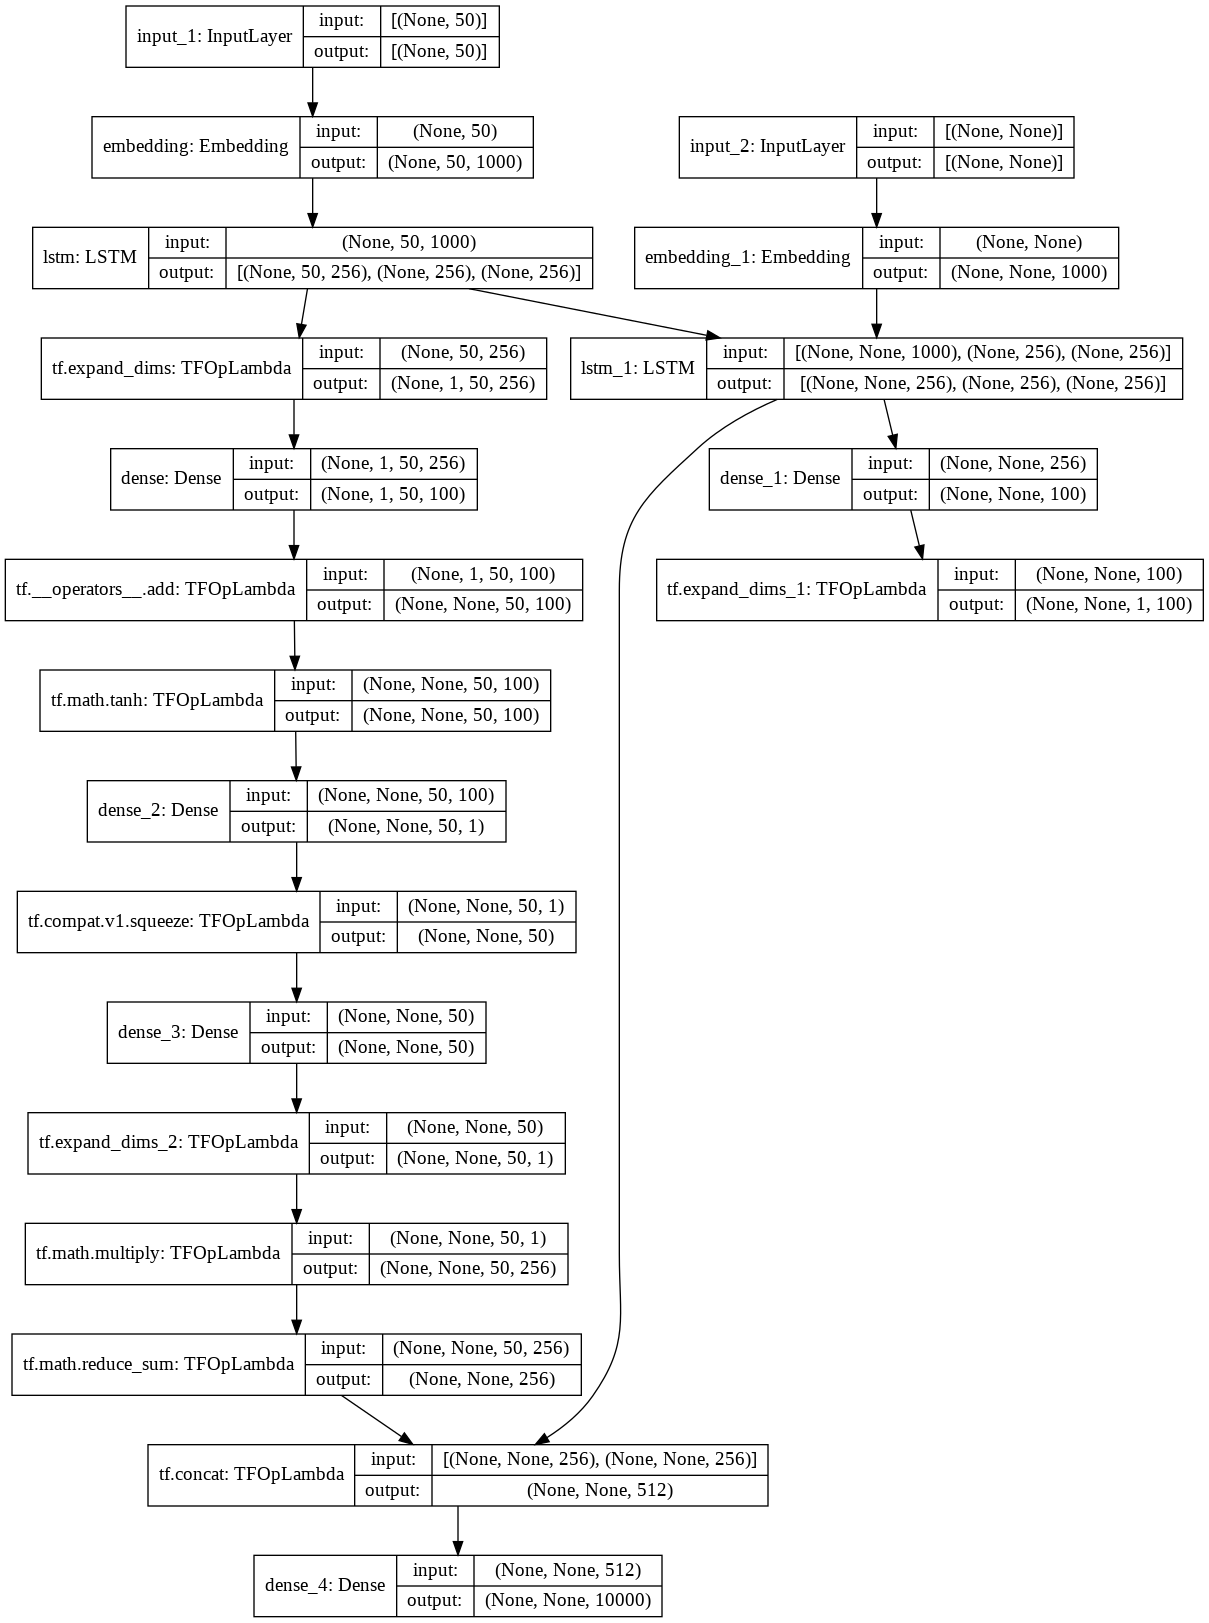

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)